<a href="https://colab.research.google.com/github/noahvlone/Project-Recommender-System/blob/main/recommender_system_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Libraries

In [1]:
# Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import precision_score, recall_score
from ast import literal_eval

# Data Load and Read Data

In [2]:
# Load data
titles = pd.read_csv('/content/titles.csv')
credits = pd.read_csv('/content/credits.csv')

# Cek struktur data
print(titles.info())
print(credits.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5850 entries, 0 to 5849
Data columns (total 15 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   id                    5850 non-null   object 
 1   title                 5849 non-null   object 
 2   type                  5850 non-null   object 
 3   description           5832 non-null   object 
 4   release_year          5850 non-null   int64  
 5   age_certification     3231 non-null   object 
 6   runtime               5850 non-null   int64  
 7   genres                5850 non-null   object 
 8   production_countries  5850 non-null   object 
 9   seasons               2106 non-null   float64
 10  imdb_id               5447 non-null   object 
 11  imdb_score            5368 non-null   float64
 12  imdb_votes            5352 non-null   float64
 13  tmdb_popularity       5759 non-null   float64
 14  tmdb_score            5539 non-null   float64
dtypes: float64(5), int64(

# Data Cleaning/Preparation

In [3]:
# Data Cleaning
print("\n## Tahapan Data Cleaning")

def parse_genres(genre_str):
    if isinstance(genre_str, str):
        if pd.isna(genre_str) or genre_str == '[]':
            return []
        genres = genre_str.strip("[]").replace("'", "").replace('"', "").split(',')
        return [g.strip() for g in genres if g.strip() != '']
    elif isinstance(genre_str, list):
        return genre_str
    else:
        return []

# Terapkan ke kolom genres
titles['genres'] = titles['genres'].fillna('[]').apply(parse_genres)
titles['description'] = titles['description'].fillna('')
titles['imdb_score'] = titles['imdb_score'].fillna(0)

# Filter hanya film (bukan TV Show)
movies = titles[titles['type'] == 'MOVIE'].copy()

# Ambil nama aktor dan direktor dari credits
credits['role'] = credits['role'].str.upper()
actors = credits[credits['role'] == 'ACTOR'].groupby('id')['name'].apply(list).reset_index()
directors = credits[credits['role'] == 'DIRECTOR'].groupby('id')['name'].apply(list).reset_index()

# Gabungkan data aktor dan direktor ke movies
movies = movies.merge(actors, on='id', how='left').rename(columns={'name': 'actors'})
movies = movies.merge(directors, on='id', how='left').rename(columns={'name': 'directors'})


## Tahapan Data Cleaning


# Exploratory Data Analysis

<ipython-input-4-77d1647e93f2>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=genres_count.values, y=genres_count.index, palette='viridis')


Text(0.5, 1.0, 'Distibusi Genre Film')

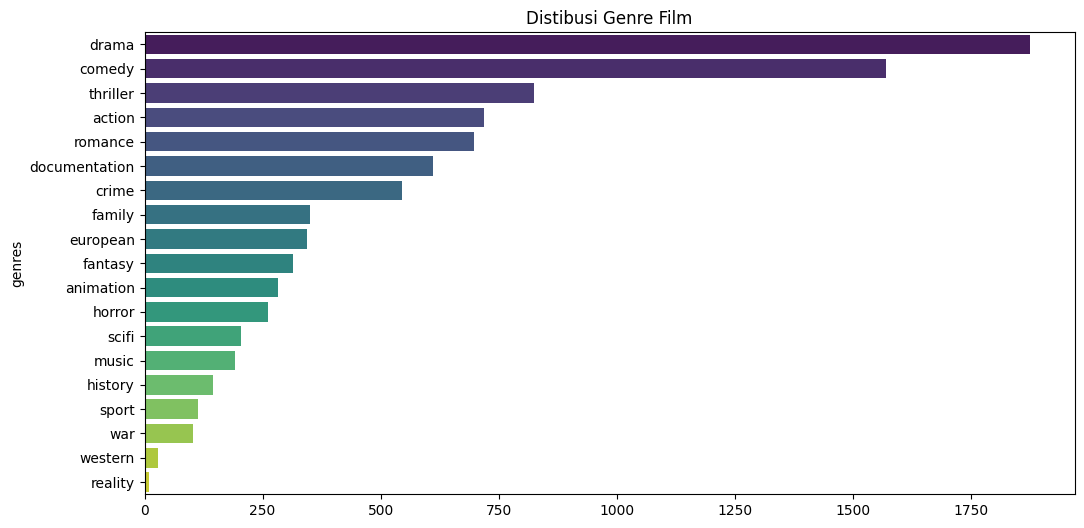

In [4]:
# Distibusi Genre
genres_count = movies['genres'].explode().value_counts()
plt.figure(figsize=(12, 6))
sns.barplot(x=genres_count.values, y=genres_count.index, palette='viridis')
plt.title('Distibusi Genre Film')

**Insight:**

- Genre drama adalah yang paling banyak muncul, diikuti oleh komedi.
Hal ini mencerminkan bahwa industri film lebih banyak memproduksi film bergenre naratif emosional dan humor, kemungkinan karena permintaan pasar yang tinggi untuk hiburan yang relatable dan ringan.
Thriller dan Action di Posisi Selanjutnya

- Thriller dan action juga memiliki jumlah yang signifikan.
Hal ini menunjukkan bahwa film yang penuh ketegangan dan aksi banyak diproduksi, kemungkinan karena daya tariknya terhadap audiens global, terutama dalam industri Hollywood dan film blockbuster.
Romance dan Dokumenter Juga Cukup Populer

- Film romance dan documentation memiliki jumlah yang lumayan besar, menunjukkan bahwa kisah percintaan dan dokumenter memiliki basis penonton yang stabil.
Dokumenter yang berkembang bisa jadi mencerminkan peningkatan minat terhadap edukasi dan realita sosial dalam bentuk audiovisual.
Genre Niche dengan Jumlah Lebih Sedikit

- Genre seperti western, war, sport, dan reality memiliki jumlah yang sangat sedikit.
Ini menunjukkan bahwa genre tersebut memiliki audiens yang lebih terbatas atau kurang populer di pasar global.

# Data Preprocessing/Preparation

### Ekstraksi Features using TF-IDF

In [5]:
# Data Preprocessing
movies['actors'] = movies['actors'].fillna('').apply(lambda x: ' '.join(x) if isinstance(x, list) else '')
movies['directors'] = movies['directors'].fillna('').apply(lambda x: ' '.join(x) if isinstance(x, list) else '')
movies['features'] = (
    movies['genres'].astype(str) + ' ' +
    movies['description'] + ' ' +
    movies['actors'] + ' ' +
    movies['directors']
)

# TF-IDF Vectorization
print("\n## Tahapan Ekstraksi Fitur dengan TF-IDF")
tfidf = TfidfVectorizer(stop_words='english', max_features=5000)
tfidf_matrix = tfidf.fit_transform(movies['features'])


## Tahapan Ekstraksi Fitur dengan TF-IDF


# Model Development (Content Based-Filtering)

### Hitung Similarity Matrix & Buat Fungsi Rekomendasi

In [6]:
# Hitung Cosine Similarity
cosine_sim = cosine_similarity(tfidf_matrix, tfidf_matrix)

# Recommendation Function
def get_recommendations(title, top_n=10):
    try:
        idx = movies[movies['title'] == title].index[0]
        sim_scores = list(enumerate(cosine_sim[idx]))
        sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
        sim_indices = [i[0] for i in sim_scores[1:top_n+1]]
        recommendations = movies.iloc[sim_indices][['title', 'genres', 'imdb_score', 'actors', 'directors']]
        recommendations['similarity_score'] = [i[1] for i in sim_scores[1:top_n+1]]
        return recommendations
    except:
        return 'Film tidak ditemukan dalam database'

# Evaluasi Model

### Evaluasi Kualitas Rekomendasi

In [7]:
# Example Evaluation
print("\nHasil Rekomendasi")
recommendations = get_recommendations('Naruto Shippuden the Movie', top_n=10)

# Markdown Table
print("\nHasil Rekomendasi untuk 'Naruto Shippuden the Movie':")
print(recommendations[['title', 'genres', 'imdb_score', 'directors', 'similarity_score']].to_markdown())


Hasil Rekomendasi

Hasil Rekomendasi untuk 'Naruto Shippuden the Movie':
|      | title                                               | genres                                                             |   imdb_score | directors          |   similarity_score |
|-----:|:----------------------------------------------------|:-------------------------------------------------------------------|-------------:|:-------------------|-------------------:|
|  322 | Naruto Shippuden the Movie: The Lost Tower          | ['animation', 'action', 'fantasy']                                 |          6.8 | Masahiko Murata    |           0.388594 |
|  330 | Naruto Shippuden the Movie: The Will of Fire        | ['action', 'comedy', 'drama', 'fantasy', 'animation']              |          7   | Masahiko Murata    |           0.354237 |
|  537 | Naruto Shippuden the Movie: Blood Prison            | ['action', 'comedy', 'horror', 'thriller', 'animation', 'fantasy'] |          7.1 | Masahiko Murata    |   

In [8]:
# Evaluation Metrics
def evaluate_recommendations(target_title, k=10):
    target_idx = movies[movies['title'] == target_title].index[0]
    sim_scores = list(enumerate(cosine_sim[target_idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_indices = [i[0] for i in sim_scores[1:k+1]]
    target_genres = set(movies.iloc[target_idx]['genres'])

    precision = 0
    recall = 0
    relevant_count = 0

    for idx in sim_indices:
        recommended_genres = set(movies.iloc[idx]['genres'])
        if target_genres.intersection(recommended_genres):
            relevant_count += 1

    precision = relevant_count / k if k else 0
    recall = relevant_count / len(target_genres) if target_genres else 0

    return {'precision@k': precision, 'recall@k': recall}


In [9]:
# Evaluasi untuk film 'The Platform'
metrics = evaluate_recommendations('Naruto Shippuden the Movie', k=10)
print("\nEvaluasi Rekomendasi:")
print(f"Precision@10: {metrics['precision@k']:.2f}")
print(f"Recall@10: {metrics['recall@k']:.2f}")


Evaluasi Rekomendasi:
Precision@10: 1.00
Recall@10: 2.50


# Save Model

In [10]:
pickle.dump(tfidf, open('tfidf_model.pkl', 'wb'))
pickle.dump(cosine_sim, open('cosine_sim.pkl', 'wb'))